<u>입력된 시퀀스로부터 다른 도메인의 시퀀스를 출력</u>하는 다양한 분야에서 사용되는 모델<br>
<blockquote><b>ex) Chatbot, Machine Translation, Text Summarization, STT(Speech to Text)</b><br>
챗봇 : 입력 시퀀스 → 질문, 출력 시퀀스 → 답변<br>
번역기 : 입력 시퀀스 → 입력 문장, 출력 시퀀스 → 번역 문장
</blockquote>

# 

# *Overview*

<b>seq2seq</b>는 번역기의 대표적인 모델<br>
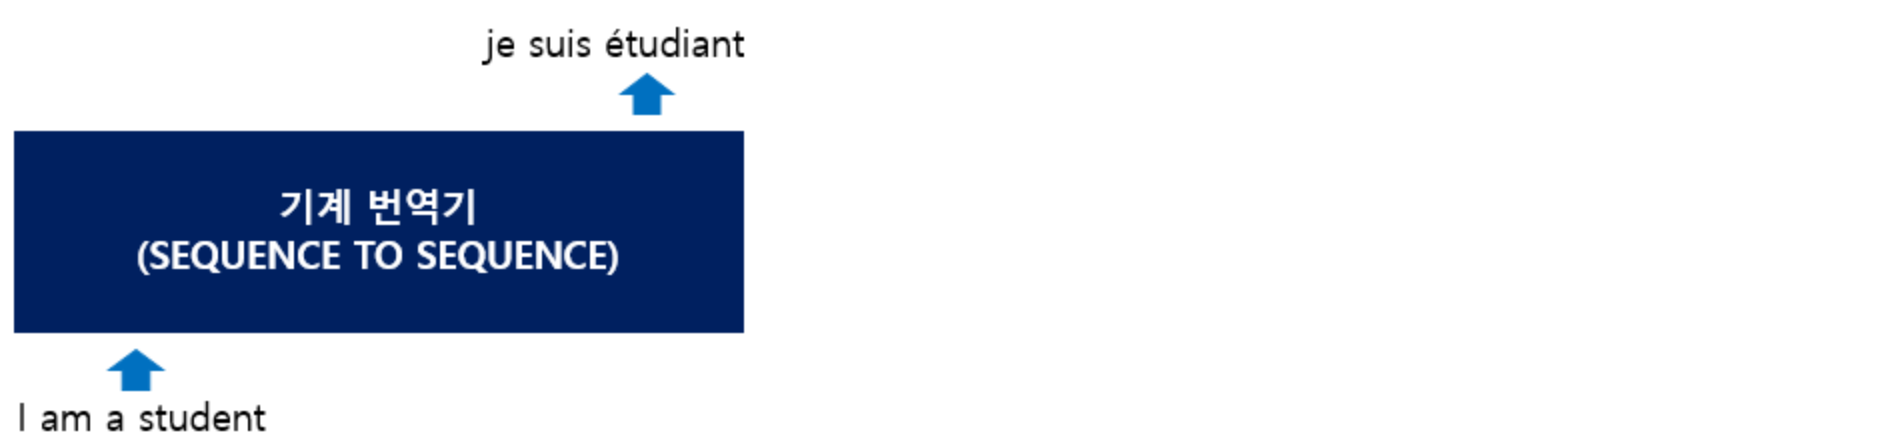
<b>seq2seq</b> 모델로 만들어진 번역기가 'I'm a student'라는 영어 문장을 입력받아 'je suis étudiant'라는 프랑스어를 출력하는 모습<br><br>

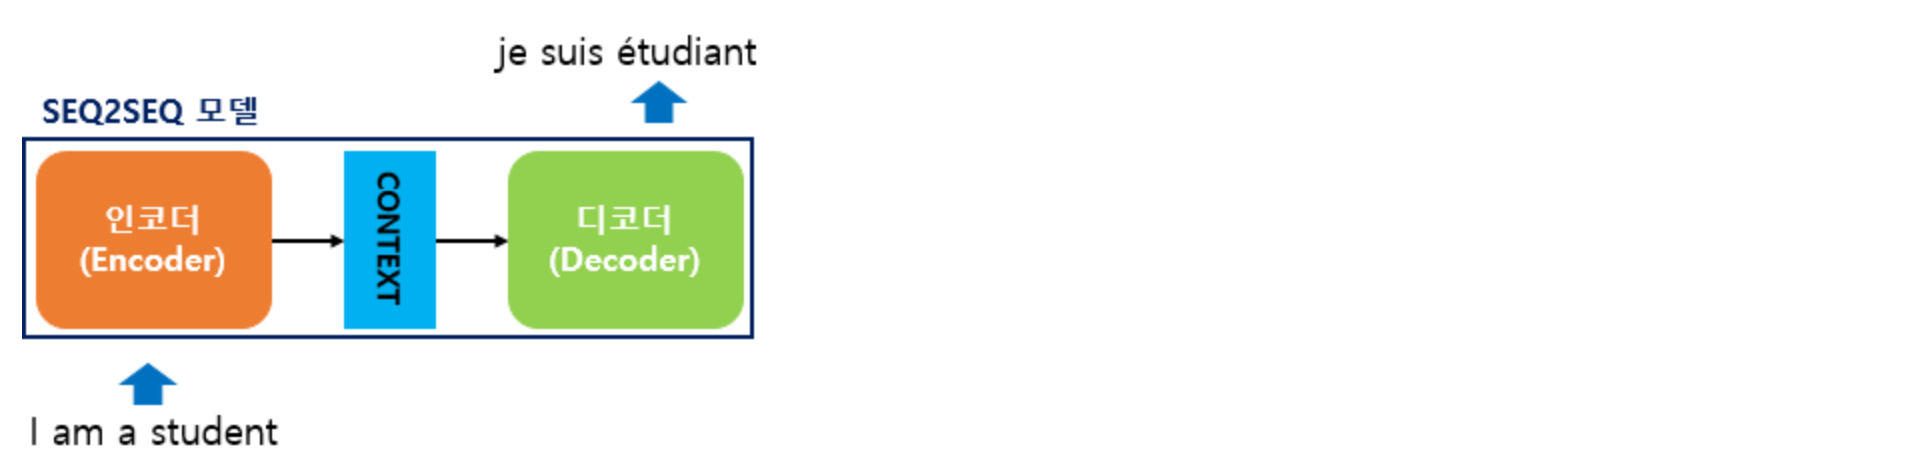
<b>인코더</b>는 입력 문장의 모든 단어들을 순차적으로 입력받은 뒤에 마지막에 모든 단어 정보들을 압축해서 하나의 벡터로 만듦(<b>Context Vector</b>, 문맥)<br>
입력 문장 정보가 하나의 컨텍스트 벡터로 모두 압축되면 인코더는 <u>컨텍스트 벡터를 디코더로 전송</u><br>
<b>디코더</b>는 컨텍스트 벡터를 받아 번역된 단어를 한 개씩 순차적으로 출력
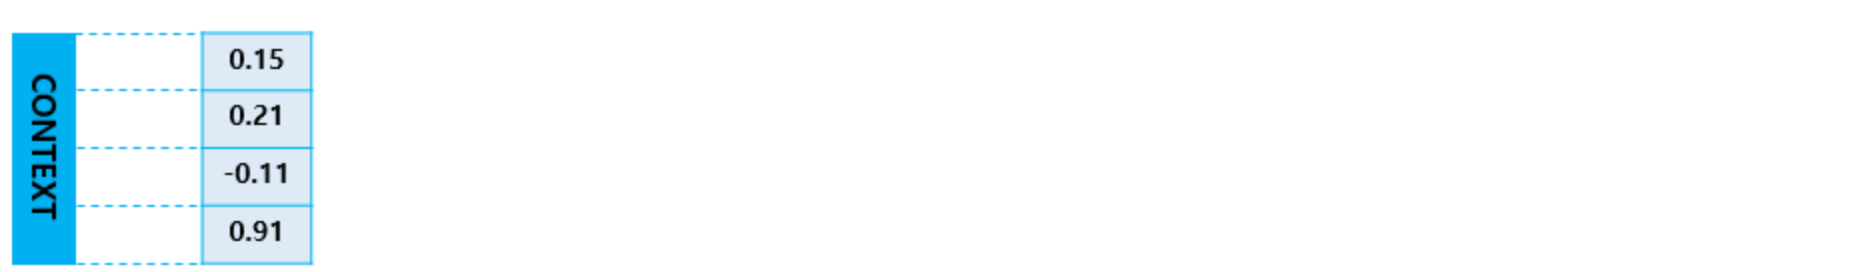

# 

# *seq2seq 동작 과정*

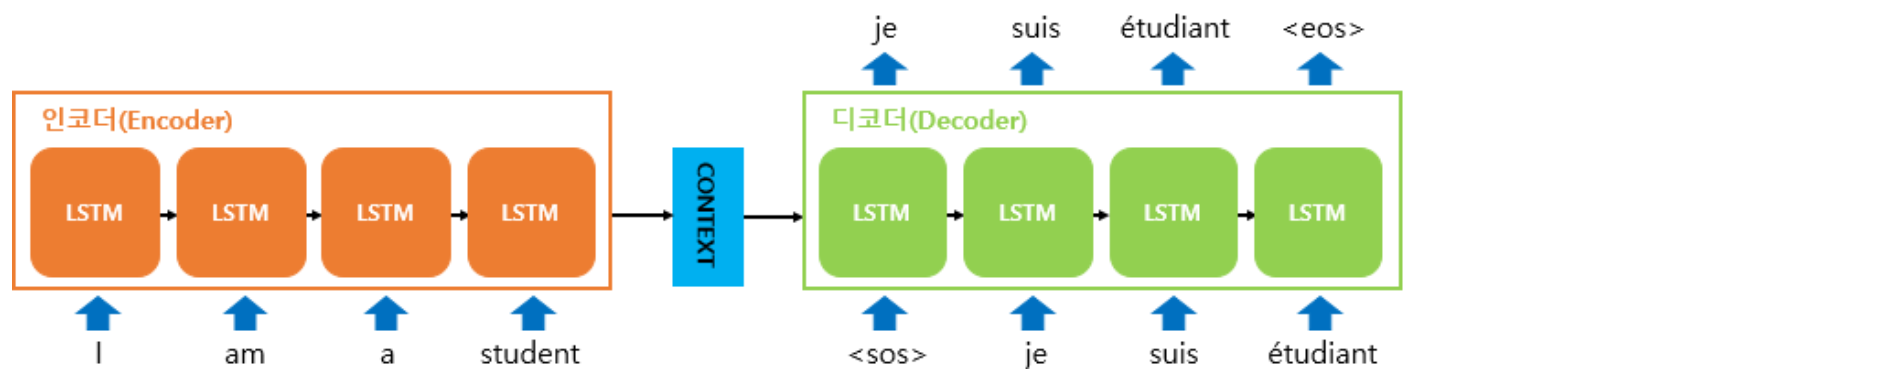
<blockquote><b>인코더</b> : 입력 문장을 받는 RNN 셀<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;입력 문장은 단어 토큰화를 통해 단어 단위로 쪼개지고 각각의 단어 토큰은 <u>RNN 셀의 각 시점의 입력이 됨</u><br>
    <b>인코더 RNN 셀</b>은 모든 단어를 입력받은 뒤 <u>인코더 RNN 셀의 마지막 시점의 은닉 상태(Context Vector)</u>를 <b>디코더 RNN 셀</b>로 넘겨줌
</blockquote>
<blockquote>
<b>디코더</b> : 출력 문장을 출력하는 RNN 셀<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>컨텍스트 벡터</b>는 <u>디코더 RNN 셀의 첫번째 은닉 상태</u>로 사용
</blockquote>
성능 문제로 실제로 Vanilla RNN이 아닌 <b>LSTM 셀, GRU 셀</b>로 구성<br>


# 

### *1. 테스트 단계*

디코더는 초기 입력으로 문장 시작을 의미하는 <b>심볼 < sos > </b>를 입력<br>
디코더는 <b> < sos > </b>가 입력되면, <u>다음에 등장할 확률이 가장 높은 단어를 예측</u><br><br>
<b>각 시점(time step)</b> 마다 디코더 RNN 셀은 다음 등장할 단어를 예측하고, 그 예측한 단어를 다음 시점의 RNN 셀의 입력으로 넣는 동작을 반복

### *2. 훈련 단계와 교사 강요*

&nbsp;&nbsp;<big><b>교사 강요</b></big><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;훈련 과정에서 인코더가 디코더로 보낸 <b>컨텍스트 벡터</b>, 실제 정답 <b> < sos> je suis étudiant </b>를 입력 받으면,<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>je suis étudiant < eos> </b>가 나와야 된다고 정답을 알려주면서 훈련

### *3. 임베딩 층(Embedding Layer)*

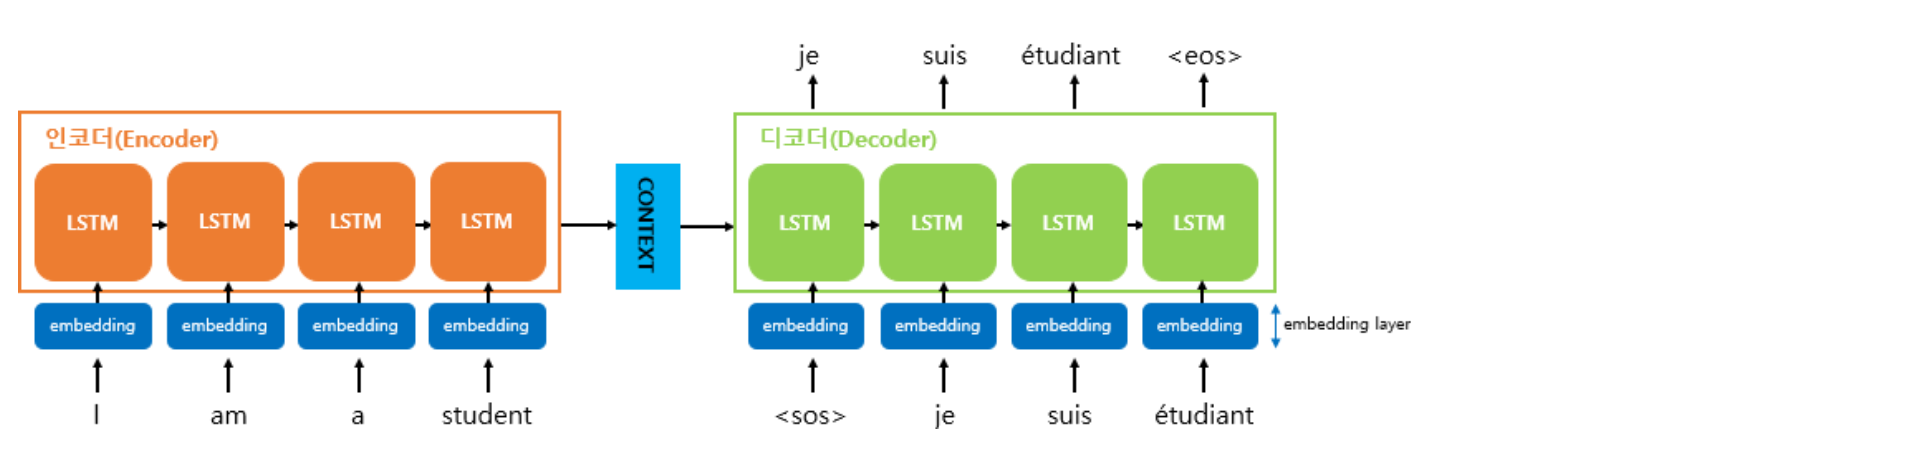
<br><br><big>임베딩 벡터</big>
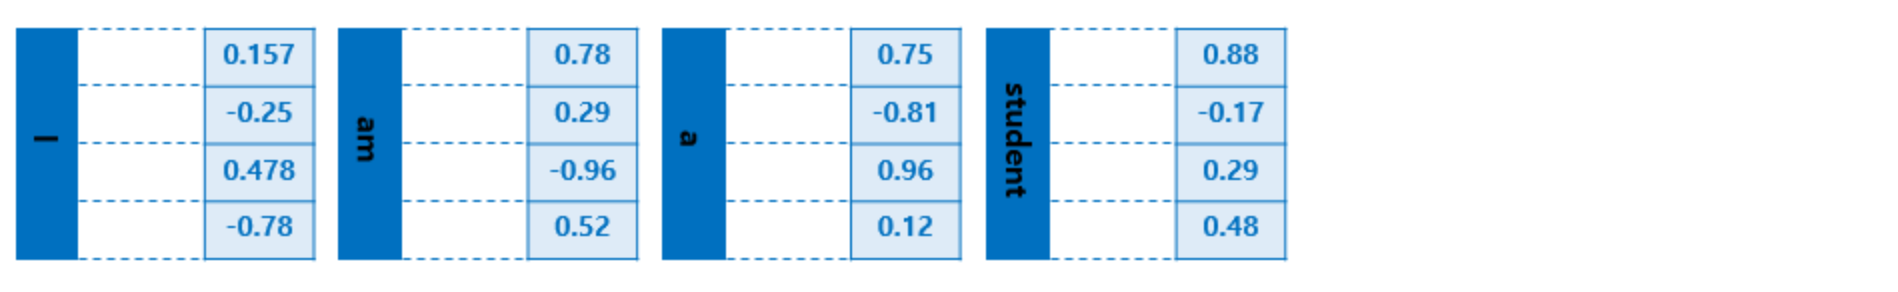

### *4. RNN 셀*

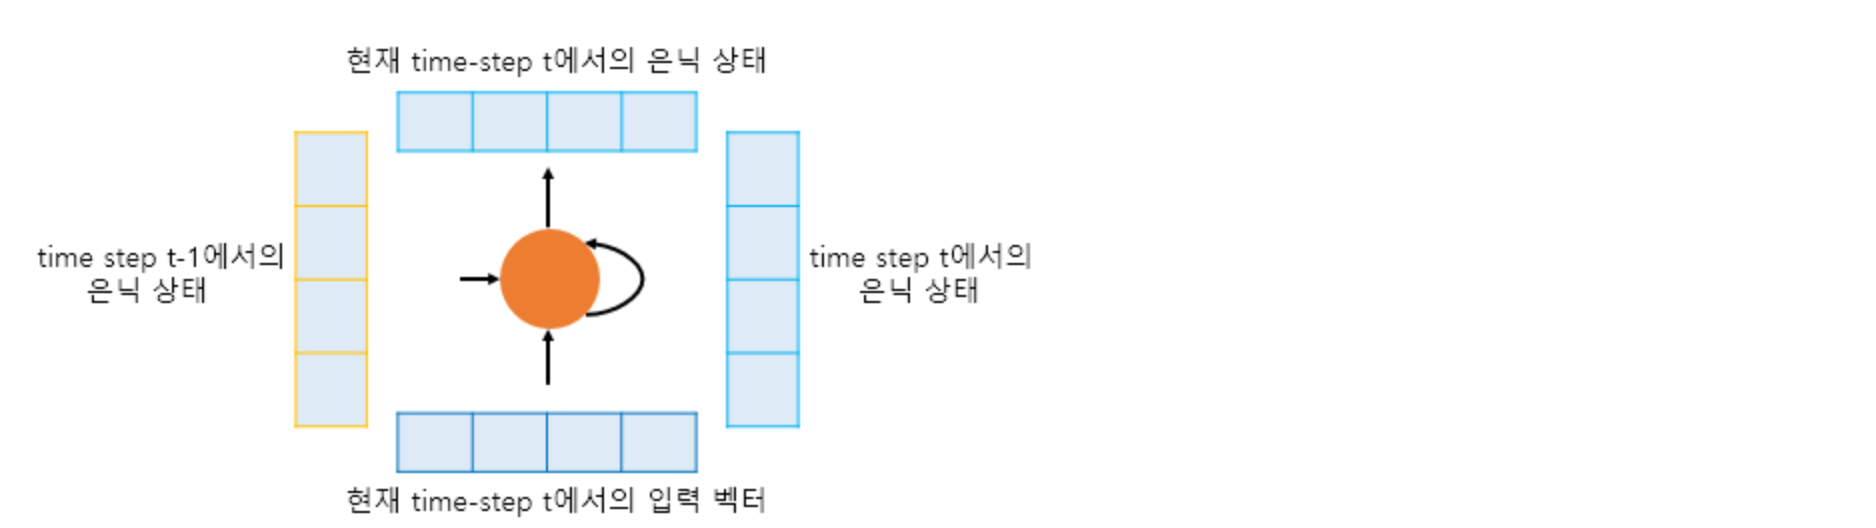
현재 시점(time step)을 t라고 할 때, RNN 셀은 <b>t-1에서의 은닉 상태</b>와 <b>t에서의 입력 벡터를 입력</b>으로 받고, t에서의 은닉 상태를 만듦<br><br>
<b>컨텍스트 벡터</b>는 인코더에서의 마지막 RNN 셀의 은닉 상태

### *5. 디코더*

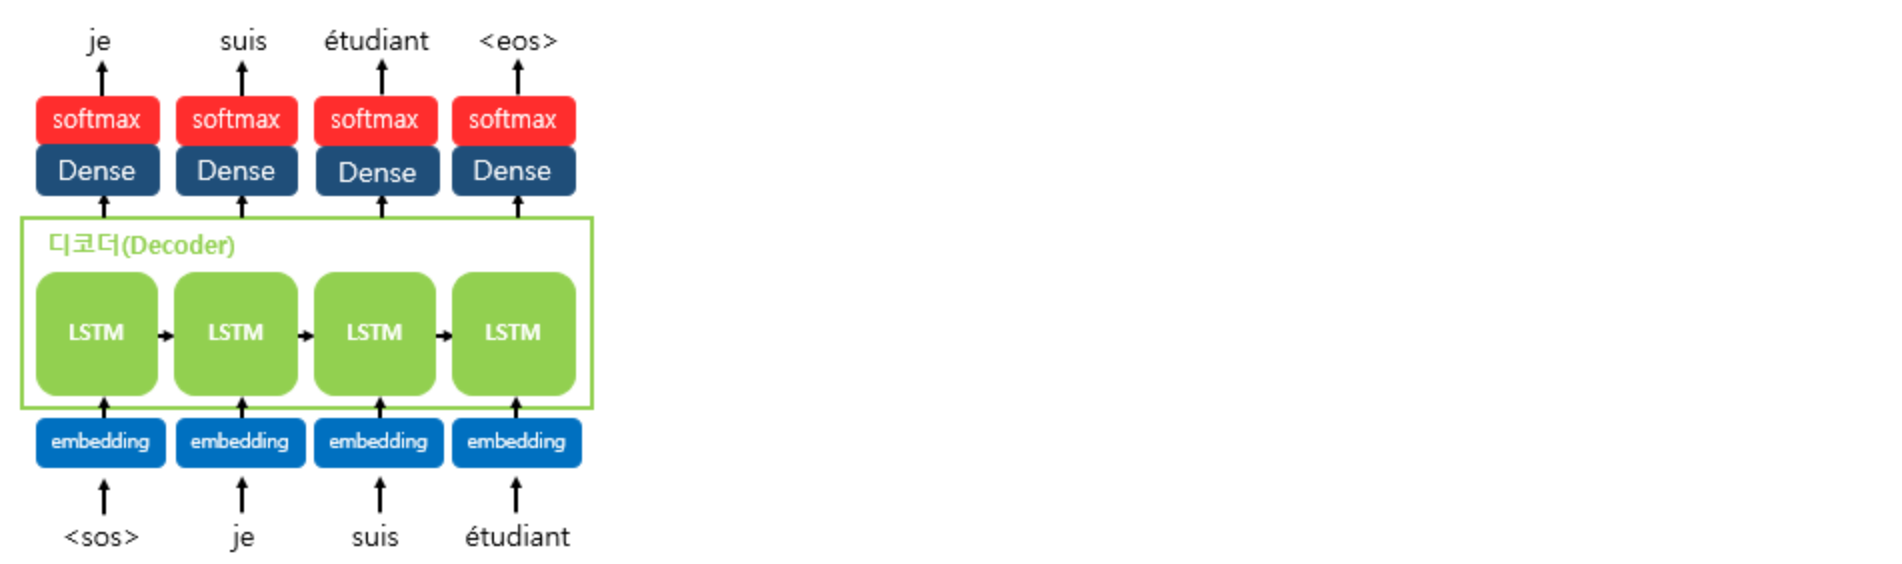
인코더의 <b>마지막 RNN 셀의 은닉 상태</b>인 <b>컨텍스트 벡터</b>를 첫번째 은닉 상태 값으로 사용<br>
디코더의 <b>첫번째 RNN 셀</b>은 이 <b>첫번째 은닉 상태 값</b>과 현재 t에서의 입력값인 <b> < sos > </b>로부터, 다음 등장할 단어를 예측<br><br>
디코더에서 각 시점(time step)의 <b>RNN 셀</b>에서 출력 벡터가 나오면,<br>
해당 벡터는 <b>소프트맥스</b> 함수를 통해 <u>출력 시퀀스의 각 단어별 확률값을 반환하고, 디코더는 출력 단어를 결정</u>

# 

## *data*

In [1]:
raw = ["I feel hungry.	나는 배가 고프다.",
        "Pytorch is very easy.	파이토치는 매우 쉽다.",
        "Pytorch is a framework for deep learning.	파이토치는 딥러닝을 위한 프레임워크이다.",
        "Pytorch is very clear to use.	파이토치는 사용하기 매우 직관적이다."
        "father enters the room.	아버지가 방에 들어가신다."
      ]

In [2]:
SOS_token = 0
EOS_token = 1

In [3]:
# read and preprocess the corpus data
# Preprocessing은 Source text와 target text를 나누어 가진다.
def preprocess(corpus, source_max_length, target_max_length):
    print("reading corpus...")
    pairs = []
    for line in corpus:
        # tab으로 구분되어 있는 것을 나누어 가진다.
        pairs.append([s for s in line.strip().lower().split("\t")])
    print("Read {} sentence pairs".format(len(pairs)))

    pairs = [pair for pair in pairs if filter_pair(pair, source_max_length, target_max_length)]
    print("Trimmed to {} sentence pairs".format(len(pairs)))

    # Vocab()을 생성하여 단어 사전 생성
    source_vocab = Vocab()
    target_vocab = Vocab()

    print("Counting words...")
    for pair in pairs:
        source_vocab.add_vocab(pair[0])
        target_vocab.add_vocab(pair[1])
    print("source vocab size =", source_vocab.n_vocab)
    print("target vocab size =", target_vocab.n_vocab)

    return pairs, source_vocab, target_vocab

In [4]:
SOURCE_MAX_LENGTH = 10
TARGET_MAX_LENGTH = 12

In [5]:
load_pairs, load_source_vocab, load_target_vocab = preprocess(raw, SOURCE_MAX_LENGTH, TARGET_MAX_LENGTH)
print(random.choice(load_pairs))

reading corpus...
Read 4 sentence pairs


NameError: name 'filter_pair' is not defined

## *model*

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')